In [1]:
import numpy as np

In [2]:
import torch
import torchvision            
import torch.nn as nn

print(torch.__version__)

1.7.0+cu101


In [3]:
from torch.utils.data import DataLoader

In [4]:
from torchvision import datasets
from torchvision import transforms

In [5]:
%matplotlib inline
from matplotlib.pyplot import imshow, imsave

In [6]:
MODEL_NAME = 'MLP'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("MODEL_NAME = {}, DEVICE = {}".format(MODEL_NAME, DEVICE))

MODEL_NAME = MLP, DEVICE = cpu


In [7]:
class HelloMLP(nn.Module):
    def __init__(self, input_size=784, num_classes=10):
        super(HelloMLP, self).__init__()
        self.mlp = nn.Sequential(             # a sequential container
            # 1st layer
            nn.Linear(input_size, 64),        # matrix multiplication (fully connected layer)            
            nn.ReLU(),                        # activation function (nn.ReLU(), nn.Tanh(), nn.Sigmoid(), etc.)
            
            # 2nd layer
            nn.Linear(64, 64),                # matrix multiplication (fully connected layer)
            nn.ReLU(),                        # activation function
            
            # 3rd (output) layer
            nn.Linear(64, num_classes),
            # nn.Softmax(),                   # not necessary because CrossEntopyLoss class includes Softmax
        )
    
    def forward(self, x):
        y_ = x.view(x.size(0), -1)            # Reshape input tensor (N, 28, 28) --> (N, 784)
        y_ = self.mlp(y_)                     # compute 
        return y_

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),                               # image to tensor
     transforms.Normalize(mean=(0.1307,), std=(0.3081,))  # normalize to "(x-mean)/std"
    ])

In [9]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving student-mat.csv to student-mat.csv
User uploaded file "student-mat.csv" with length 56993 bytes


In [45]:
import pandas as pd
dataset = pd.read_csv("student-mat.csv", names = ["school","sex","age","address","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","guardian","traveltime","studytime","failures","schoolsup","famsup","paid","activities","nursery","higher","internet","romantic","famrel","freetime","goout","Dalc","Walc","health","absences","G1","G2","G3"])
print(dataset.size)
dataset_input = dataset.iloc[:,-3:]
dataset_target = dataset.iloc[:,:-3]
print(dataset_input)
print(dataset_target)

13068
     G1  G2  G3
0   NaN NaN NaN
1   NaN NaN NaN
2   NaN NaN NaN
3   NaN NaN NaN
4   NaN NaN NaN
..   ..  ..  ..
391 NaN NaN NaN
392 NaN NaN NaN
393 NaN NaN NaN
394 NaN NaN NaN
395 NaN NaN NaN

[396 rows x 3 columns]
                                                school  sex  ...  health  absences
0    school;sex;age;address;famsize;Pstatus;Medu;Fe...  NaN  ...     NaN       NaN
1    GP;"F";18;"U";"GT3";"A";4;4;"at_home";"teacher...  NaN  ...     NaN       NaN
2    GP;"F";17;"U";"GT3";"T";1;1;"at_home";"other";...  NaN  ...     NaN       NaN
3    GP;"F";15;"U";"LE3";"T";1;1;"at_home";"other";...  NaN  ...     NaN       NaN
4    GP;"F";15;"U";"GT3";"T";4;2;"health";"services...  NaN  ...     NaN       NaN
..                                                 ...  ...  ...     ...       ...
391  MS;"M";20;"U";"LE3";"A";2;2;"services";"servic...  NaN  ...     NaN       NaN
392  MS;"M";17;"U";"LE3";"T";3;1;"services";"servic...  NaN  ...     NaN       NaN
393  MS;"M";21;"R";"GT3";"T";1;

In [47]:
batch_size = 64

In [46]:
# utility function to measure time
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [49]:
model = HelloMLP()
all_losses = []


In [50]:
# set loss function
loss_fn = nn.CrossEntropyLoss()

# set optimizer
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
max_epoch = 5        # maximum number of epochs
step = 0             # initialize step counter variable
plot_every = 200
total_loss = 0 # Reset every plot_every iters
start = time.time()
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(train_loader):
        x, y = images.to(DEVICE), labels.to(DEVICE) # (N, 1, 28, 28), (N, )
        y_hat = model(x)            # forward propagation, y_hat.shape = (N, 10)
        loss = loss_fn(y_hat, y)    # computing loss
        total_loss += loss.item()
        
        optim.zero_grad()           # reset gradient
        loss.backward()             # back-propagation (compute gradient)
        optim.step()                # update parameters with gradient
        # periodically print loss
        if step % 500 == 0:
            print('Epoch({}): {}/{}, Step: {}, Loss: {}'.format(timeSince(start), epoch, max_epoch, step, loss.item()))
        
        if (step + 1) % plot_every == 0:
            all_losses.append(total_loss / plot_every)
            total_loss = 0
        
        # periodically evalute model on test data
        if step % 1000 == 0:
            model.eval()
            acc = 0.
            with torch.no_grad():   # disable autograd
                for idx, (images, labels) in enumerate(test_loader):
                    x, y = images.to(DEVICE), labels.to(DEVICE) # (N, 1, 28, 28), (N, )
                    y_hat = model(x) # (N, 10)
                    loss = loss_fn(y_hat, y)
                    _, indices = torch.max(y_hat, dim=-1)     # find maxmum along the last axis (argmax of each row)
                                                              # ex) max_value, max_idx = torch.max(input, dim)
                    acc += torch.sum(indices == y).item()     # count correctly classified samples
                                                              # torch.sum() returns Tensor. Tensor.item() converts it to a value
            print('*'*20, 'Test', '*'*20)
            print('Step: {}, Loss: {}, test accuracy: {} %'.format(step, loss.item(), acc/len(mnist_test)*100))
            print('*'*46)
            model.train()           # turn to train mode (enable autograd)
        step += 1

Epoch(0m 0s): 0/5, Step: 0, Loss: 2.3060011863708496
******************** Test ********************
Step: 0, Loss: 2.2812917232513428, test accuracy: 19.900000000000002 %
**********************************************
Epoch(0m 9s): 0/5, Step: 500, Loss: 0.18559880554676056
Epoch(0m 16s): 1/5, Step: 1000, Loss: 0.16547027230262756
******************** Test ********************
Step: 1000, Loss: 0.2911972105503082, test accuracy: 94.51 %
**********************************************
Epoch(0m 25s): 1/5, Step: 1500, Loss: 0.06006455421447754
Epoch(0m 32s): 2/5, Step: 2000, Loss: 0.1004827544093132
******************** Test ********************
Step: 2000, Loss: 0.12110922485589981, test accuracy: 95.88 %
**********************************************
Epoch(0m 41s): 2/5, Step: 2500, Loss: 0.044795796275138855
Epoch(0m 48s): 3/5, Step: 3000, Loss: 0.02942034602165222
******************** Test ********************
Step: 3000, Loss: 0.0755758211016655, test accuracy: 96.82 %
*****************

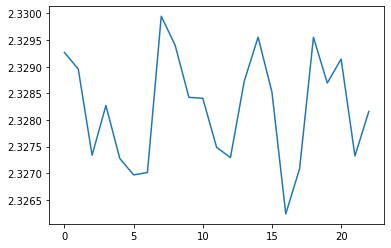

In [64]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [ ]:
# save parameters, if necessary.
torch.save(model.state_dict(), 'model.pkl')

In [ ]:
어떻게 풀지 잘 감이 안잡힙니다 ㅠㅠ 더 공부해보겠습니다...